In [1]:
!pip install tensorflow-determinism

  Preparing metadata (setup.py) ... - done
Discarding https://files.pythonhosted.org/packages/76/56/79d74f25b326d8719753172496abc524980fa67d1d98bb247021376e370a/tensorflow-determinism-0.3.0.tar.gz#sha256=563316b785614df300bbdec9b3c45a94d212761aec796cf1aafcbb2f69fdeb01 (from https://pypi.org/simple/tensorflow-determinism/): Requested tensorflow-determinism from https://files.pythonhosted.org/packages/76/56/79d74f25b326d8719753172496abc524980fa67d1d98bb247021376e370a/tensorflow-determinism-0.3.0.tar.gz#sha256=563316b785614df300bbdec9b3c45a94d212761aec796cf1aafcbb2f69fdeb01 has inconsistent version: filename has '0.3.0', but metadata has '0.4.1'
  Preparing metadata (setup.py) ... - done
Discarding https://files.pythonhosted.org/packages/9b/28/4aa0d8f183d13d3477626e931a3363651bb8e291165d58962a39c57ae7fb/tensorflow-determinism-0.2.0.tar.gz#sha256=1e364b142acd96ec8a8fca6dee32ef04e1c5f5ca20bd83fc9ec37f7dbf2fb5b5 (from https://pypi.org/simple/tensorflow-determinism/): Requested tensorflow

# Import libraries

In [2]:
import os
import io
import random

import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import TextVectorization

print("Tensorflow version:", tf.__version__)

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Tensorflow version: 2.6.4


In [3]:
SEED = 42
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def set_global_determinism(seed):
    set_seeds(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED)

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# Import dataset and EDA

In [5]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.shape

(50000, 2)

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df['sentiment'].value_counts().plot(kind='bar')

In [8]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [9]:
for row in df.head(2).itertuples():
    print("Review -->", row.review)
    print('Sentiment -->', row.sentiment, '\n')

Review --> One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due

# Train Test Split

In [10]:
train, test = train_test_split(df, test_size=0.2, stratify=df['sentiment'])
train, validation = train_test_split(train, test_size=0.2, stratify=train['sentiment'])

train.shape, validation.shape, test.shape

((32000, 2), (8000, 2), (10000, 2))

In [11]:
training_dataset = tf.data.Dataset.from_tensor_slices(
    (train['review'].values, train['sentiment'].values)).batch(batch_size=32)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (validation['review'].values, validation['sentiment'].values)).batch(batch_size=32)

## Bag of Words (Count Vectorizer)

In [12]:
vocab_size = 10000   

count_vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='count',
)

count_vectorizer.adapt(train['review'].values)

2022-11-30 04:57:13.980653: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [13]:
count_vectorizer.get_vocabulary()[:10]

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'i', 'it']

In [14]:
count_vectorizer(['It was the best movie I watched in recent times']).numpy()

array([[0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## TF-IDF Vectorizer

In [15]:
vocab_size = 10000       

tfidf_vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='tf_idf',
    ngrams=(2,3)
)

tfidf_vectorizer.adapt(train['review'].values)

In [16]:
tfidf_vectorizer.get_vocabulary()[:10]

['[UNK]',
 'of the',
 'in the',
 'this movie',
 'and the',
 'is a',
 'the film',
 'to the',
 'to be',
 'the movie']

In [17]:
tfidf_vectorizer(['It was the best movie I watched in recent times']).numpy()

array([[35.378265,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

# Model

## Count Vectorizer model

In [18]:
model1 = Sequential([
    count_vectorizer,
    layers.Dense(64, activation='relu', kernel_regularizer=L2(1e-3)),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu', kernel_regularizer=L2(1e-3)),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])

model1.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history = model1.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=5,
    validation_data=validation_dataset,
    validation_steps=len(validation_dataset)
)

Epoch 1/5
1000/1000 [==============================] - 12s 11ms/step - loss: 0.4455 - accuracy: 0.8531 - val_loss: 0.3793 - val_accuracy: 0.8871
Epoch 2/5
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3724 - accuracy: 0.8935 - val_loss: 0.3917 - val_accuracy: 0.8889
Epoch 3/5
1000/1000 [==============================] - 12s 11ms/step - loss: 0.3486 - accuracy: 0.9082 - val_loss: 0.4174 - val_accuracy: 0.8834
Epoch 4/5
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3359 - accuracy: 0.9201 - val_loss: 0.4586 - val_accuracy: 0.8771
Epoch 5/5
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3234 - accuracy: 0.9267 - val_loss: 0.4587 - val_accuracy: 0.8796


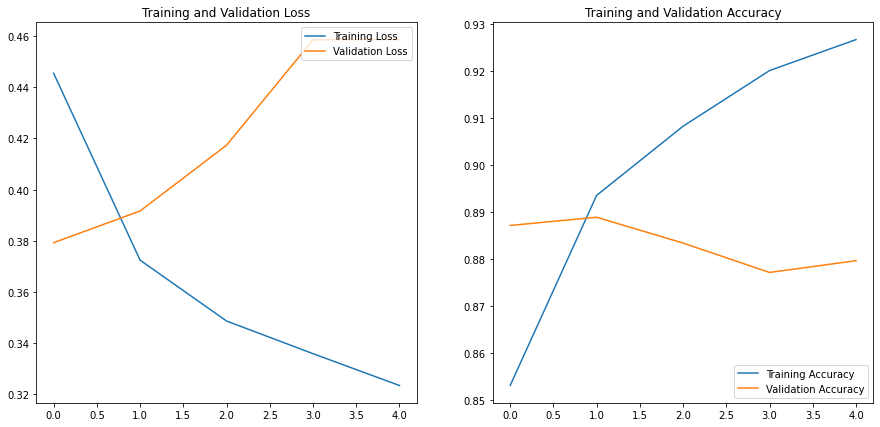

<Figure size 720x432 with 0 Axes>

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure(figsize=(10, 6));

In [20]:
model1.evaluate(validation_dataset, batch_size=32, verbose=1)

250/250 [==============================] - 1s 5ms/step - loss: 0.4587 - accuracy: 0.8796


[0.45866891741752625, 0.8796250224113464]

## TF-IDF Model

In [21]:
model2 = Sequential([
    tfidf_vectorizer,
    layers.Dense(64, activation='relu', kernel_regularizer=L2(1e-3)),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu', kernel_regularizer=L2(1e-3)),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])

model2.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history = model2.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=5,
    validation_data=validation_dataset,
    validation_steps=len(validation_dataset)
)

Epoch 1/5
1000/1000 [==============================] - 14s 13ms/step - loss: 0.6895 - accuracy: 0.7895 - val_loss: 0.4749 - val_accuracy: 0.8547
Epoch 2/5
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4703 - accuracy: 0.8545 - val_loss: 0.4931 - val_accuracy: 0.8419
Epoch 3/5
1000/1000 [==============================] - 12s 12ms/step - loss: 0.4464 - accuracy: 0.8577 - val_loss: 0.5002 - val_accuracy: 0.8394
Epoch 4/5
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4117 - accuracy: 0.8691 - val_loss: 0.4545 - val_accuracy: 0.8541
Epoch 5/5
1000/1000 [==============================] - 12s 12ms/step - loss: 0.3845 - accuracy: 0.8773 - val_loss: 0.4972 - val_accuracy: 0.8214


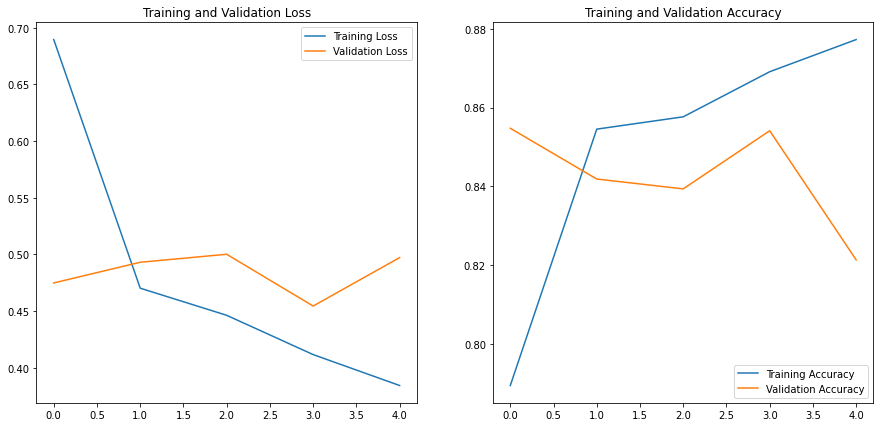

<Figure size 720x432 with 0 Axes>

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure(figsize=(10, 6));

In [23]:
model2.evaluate(validation_dataset, batch_size=32, verbose=1)

250/250 [==============================] - 2s 7ms/step - loss: 0.4972 - accuracy: 0.8214


[0.4972485899925232, 0.8213750123977661]

# Predict on test set

In [24]:
predictions = model1.predict(test['review']).round()
accuracy_score(test['sentiment'].values, predictions)

0.8729